used tutorial: https://muthu.co/segmenting-lines-in-handwritten-documents-using-a-path-planning-algorithm/

# TO DO:


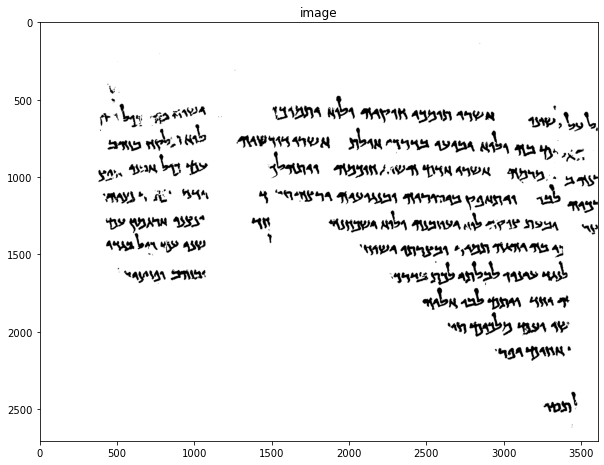

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2
import numpy as np


easy_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P168-Fg016-R-C01-R01-binarized.jpg'
hard_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P22-Fg008-R-C01-R01-binarized.jpg' 
huge_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P344-Fg001-R-C01-R01-binarized.jpg'
half_sentences_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P106-Fg002-R-C01-R01-binarized.jpg'
divided_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P423-1-Fg002-R-C01-R01-binarized.jpg' 
curly_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P123-Fg002-R-C01-R01-binarized.jpg' 
vague_scroll = r'/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/image-data/P166-Fg007-R-C01-R01-binarized.jpg'


image = cv2.imread(divided_scroll, cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(10,10))
plt.axis()
plt.title("image")
plt.imshow(image, cmap="gray")
plt.show()

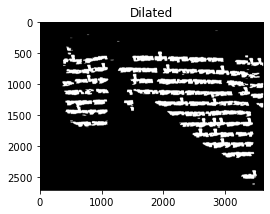

In [2]:
#maybe use this instead of the other gray image becaus here the small things are removed and we can find a better path i think.

def thresholding(image):
    _ ,thresh = cv2.threshold(image,80,255,cv2.THRESH_BINARY_INV)
#     plt.figure(figsize=(4,4))
#     plt.title("Thresholded")
#     plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(image)

#dilation
#We can change the dilation to create larger letters if we want to.first num is vertical, second num is horizontal dilation
#3,15 is the one used since the beginning, we can change to other settings if we like
kernel = np.ones((4,35), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)

plt.figure(figsize=(4,4))
plt.title("Dilated")
plt.imshow(dilated, cmap='gray')
plt.show()

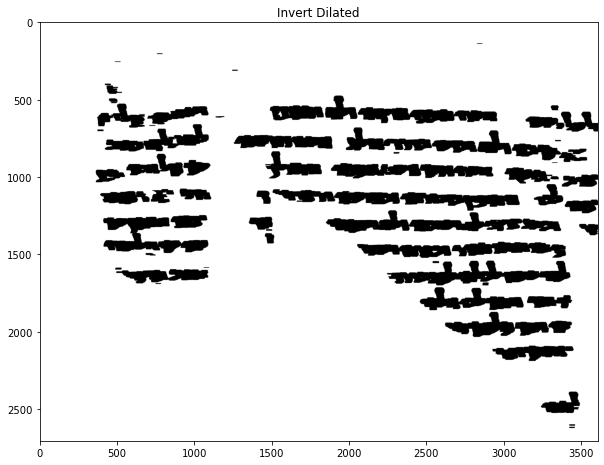

In [3]:
#Invert the image back from black background to white background, for the path finder. 
invert = cv2.bitwise_not(dilated)

plt.figure(figsize=(10,10))
plt.imshow(invert, cmap='gray')
plt.title("Invert Dilated")
plt.show()

img = invert

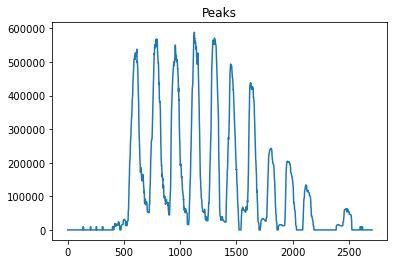

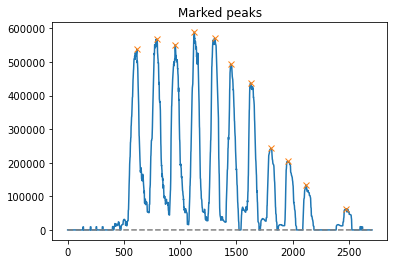

In [4]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def horizontal_projections(image):
    return np.sum(image, axis=1) 

hpp = horizontal_projections(dilated)
plt.plot(hpp)
plt.title("Peaks")
plt.show()


# The minimum_peak is just a treshold value for what number a peak minimum has to consist of. 
# The distance in the find_peaks() function seperates the peaks by a distance of minimum of 100. With the highest peak being selected. 
minimum_peak = int((np.max(hpp)-np.min(hpp))/12)
peaks, _ = find_peaks(hpp, height=minimum_peak, distance=100)
plt.plot(hpp)
plt.title("Marked peaks")
plt.plot(peaks, hpp[peaks], "x")
plt.plot(np.zeros_like(hpp), "--", color="gray")
plt.show()

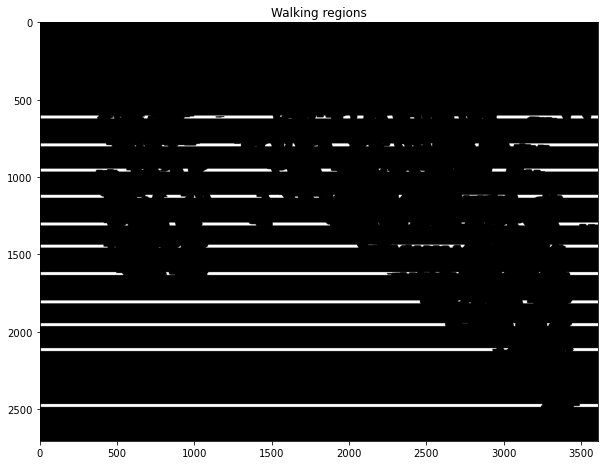

In [5]:
#Use the calculated peaks to create small areas of where there must be sentences. 
def find_not_peak_regions(hpp):
    not_peaks = []
    not_peaks_index = []
    count = 0
    x = 0
    line_size = 10
    for i, hppv in enumerate(hpp):
        if x > (len(peaks) - 1):
            not_peaks.append([i, hppv])
        elif i < (peaks[x] - line_size) or i > (peaks[x] + line_size):
            not_peaks.append([i, hppv])
        else:
            count += 1
            if count == ((line_size*2) - 1):
                x += 1
                count = 0
    return not_peaks

not_peaks = find_not_peak_regions(hpp)

not_peaks_index = np.array(not_peaks)[:,0].astype(int)


#Displays the image below
segmented_img = np.copy(img)
r,c = segmented_img.shape
for ri in range(r):
    if ri in not_peaks_index:
        segmented_img[ri, :] = 0
        
plt.figure(figsize=(10,10))
plt.title("Walking regions")
plt.imshow(segmented_img, cmap="gray")
plt.show()

In [6]:
#The Hpp_clusters is the black areas such that we have walking regions for the algorithm

#Create walking regions in the image
def get_hpp_walking_regions(peaks_index):
    hpp_clusters = []
    cluster = []
    for index, value in enumerate(peaks_index):
        cluster.append(value)

        if index < len(peaks_index)-1 and peaks_index[index+1] - value > 1:
            hpp_clusters.append(cluster)
            cluster = []

        #get the last cluster
        if index == len(peaks_index)-1:
            hpp_clusters.append(cluster)
            cluster = []
            
    return hpp_clusters

hpp_clusters = get_hpp_walking_regions(not_peaks_index)

In [7]:
#Copied from the github mentioned above, adjusted for our problem. Created a range of goals.

#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):
    
    #print("start: " + str(start))
    #print("end: " + str(goal))
    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    lower_limit = goal[0]
    upper_limit = goal[0] + lower_limit 
    
    count = 0
    while oheap:
        count += 1
        
        current = heappop(oheap)[1]
        
        #If there is not a path break after 100 times the length of the input iterations
        if count > goal[1]*30:
            break
            
        #The goal of the path finder can be somewhere in the range of the walking region at the end
        if current[1] == goal[1] and (current[0] > lower_limit and current[0] < upper_limit):
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))      
    return []

In [8]:
# #Copied from the github mentioned above
from skimage.filters import threshold_otsu

def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary*1
    return binary

In [9]:
#Segment all the lines using the A* algorithm
binary_image = get_binary(img)

line_segments = []
for i, cluster_of_interest in enumerate(hpp_clusters):
    nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[len(cluster_of_interest)-1],:]
    
    #The goal given is the middle of the walking region. But we adjusted in the path finder to the complete range.
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2), nmap.shape[1]-1)))
   
    #Finding a path is impossible, then just draw a straight line from begin to end
    if path.shape[0] == 0:
        line_new = []
        size_cluster = int(nmap.shape[0]/2)
        for i in range(nmap.shape[1] - 1):
            line_new.append([size_cluster, nmap.shape[1]-i -1])
            line = []
        line_new = np.asarray(line_new)
        offset_from_top = cluster_of_interest[0]
        line_new[:,0] += offset_from_top
        line_segments.append(line_new)
    else:
        offset_from_top = cluster_of_interest[0]
        path[:,0] += offset_from_top
        line_segments.append(path)

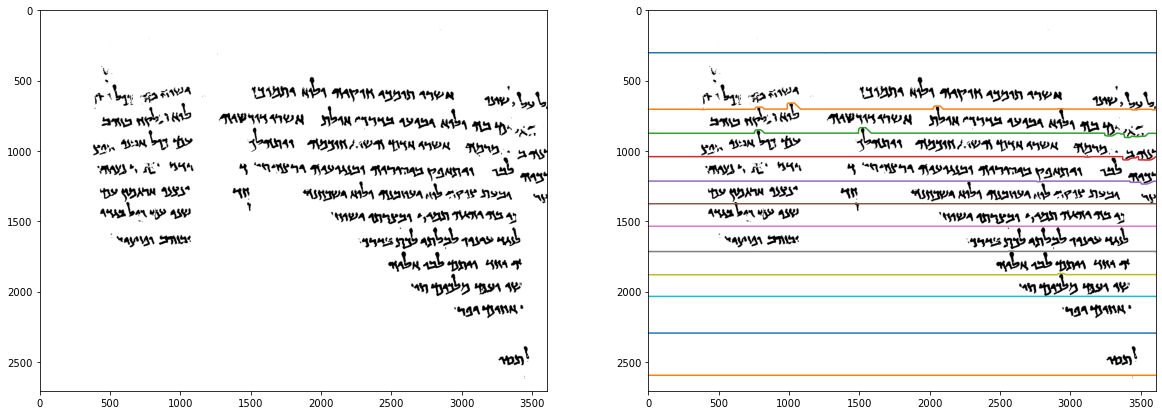

In [10]:
#Print the created path throught the first inputted image
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,20), ncols=2)
for path in line_segments:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].axis()
ax[0].axis()
ax[1].imshow(image, cmap="gray")
ax[0].imshow(image, cmap="gray")

In [11]:
from PIL import Image

def white_array(height, width):
    image = np.zeros([height,width],dtype=np.uint8)
    image.fill(255)
    return image

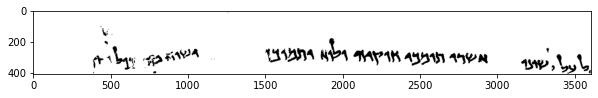

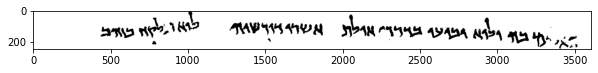

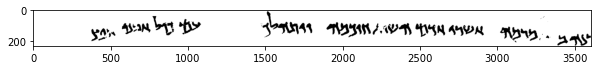

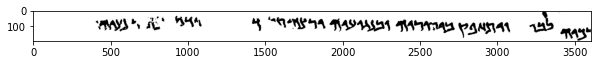

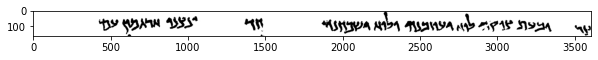

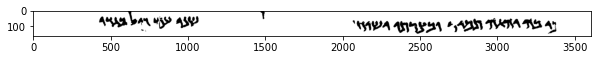

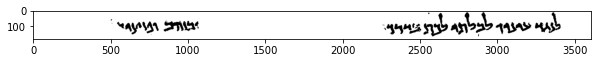

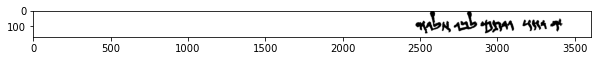

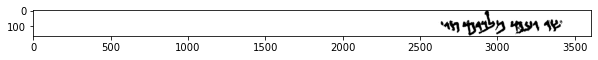

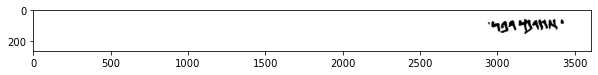

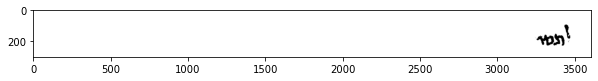

In [12]:
#Loop to create the seperate line images
line_count = len(line_segments)
line_image = []

for line_index in range(line_count-1):
    upper_bound = np.min(line_segments[line_index][:, 0])
    lower_bound = np.max(line_segments[line_index+1][:, 0])
    height = lower_bound - upper_bound
    width = image.shape[1]
    white_line_image = white_array(height, width)
    offset_top = upper_bound
    
    
    #Creates white areas around the sentences, such that bits and pieces of other sentences do not get in the line image
    for i in range(white_line_image.shape[0]):
        for j in range(white_line_image.shape[1] -1):
            if (line_segments[line_index][white_line_image.shape[1] - 2 - j][0] - i > upper_bound) or (i + offset_top > line_segments[line_index+1][white_line_image.shape[1] - 2 - j][0]) :              
                white_line_image[i][j] = 255     
            else:
                white_line_image[i][j] = image[upper_bound + i][j]

    line_image.append(white_line_image)
    
    plt.figure(figsize=(10,10))
    plt.imshow(white_line_image, cmap="gray")
    plt.show()

## Word segmentation

First we need to downsize the white part in the first and last lines.

# First option for word segmentation

In [13]:
def remove_top_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)):
        if hpp_image[i] != 0:
            image_new = image[i:, :]
            break 
    return image_new

def remove_bottom_image(image):
    thresh_image = thresholding(image)
    hpp_image = horizontal_projections(thresh_image)
    for i in range(len(hpp_image)-1, 0, -1):
        if hpp_image[i] != 0:
            image_new = image[:i, :]
            break 
    return image_new



first_line = line_image[0]
last_line = line_image[len(line_image)-1]

line_image[0] = remove_top_image(first_line)
line_image[len(line_image)-1] = remove_bottom_image(last_line)    

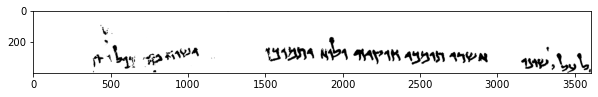

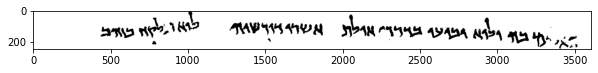

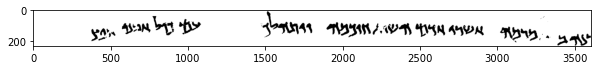

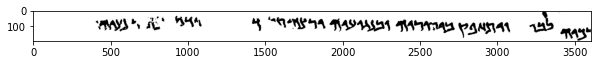

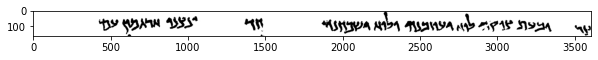

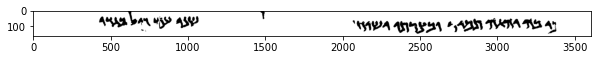

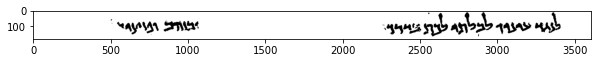

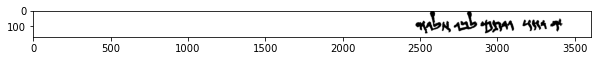

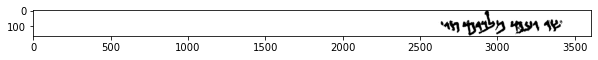

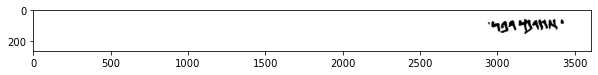

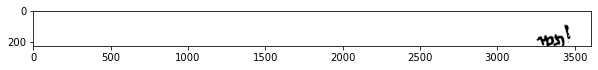

In [14]:
for i in range(len(line_image)):
    plt.figure(figsize=(10,10))
    plt.imshow(line_image[i], cmap="gray")
    plt.show()

In [15]:
def vertical_projections(image):
    return np.sum(image, axis=0) 

def remove_noise(image):
    return cv2.medianBlur(image, 5)

#preprocesses the lines
def pre_process_lines(lines):
    pre_processed_lines = []
    kernel = np.ones((10,10), np.uint8)
    
    for i in range(len(lines)):
        line = lines[i]
        
        #threshold line
        thresh_line = thresholding(line)
        
        #remove noise
        noise_free_line = remove_noise(thresh_line)
        
        #dilate the remaining part
        dilated_line = cv2.dilate(noise_free_line, kernel, iterations = 1)
        
        #append the line
        pre_processed_lines.append(dilated_line)
    return pre_processed_lines


pre_processed_lines = pre_process_lines(line_image)

# Based on white areas pixels that are shorter than a certain amount

In [360]:
def find_words_for_zero_period(image, threshold):
    words = []
    vpp_image = vertical_projections(image)
    
    #find indexes where the vpp is not zero, so there are black pixels
    result_zeros = np.where(vpp_image!=0)
    #print(result_zeros)
    lowest = result_zeros[0][0]
    for i in range(len(result_zeros[0])-1):
        #print("i: " +str(i) + " " +str(result_zeros[0][i]) + " "+ str(lowest))
        diff = result_zeros[0][i+1] - result_zeros[0][i] 
        #skip white periods that are not long enough
        if diff > 1 and diff < threshold:
            continue
        elif diff > 1:
            highest = result_zeros[0][i]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]
            
    if lowest + 70 < result_zeros[0][len(result_zeros[0])-1]:
            highest = result_zeros[0][len(result_zeros[0])-1]
            new_word = [lowest, highest]
            words.append(new_word)
            lowest = result_zeros[0][i+1]       
    
    return words 

def get_word_image(image, index_words):
    words = []
    for i in range(len(index_words)):
        #Get word
        word_new = image[:,index_words[i][0]:index_words[i][1]]
        
        #remove the white area at the top and bottom
        word_bot = remove_bottom_image(word_new)
        word_top = remove_top_image(word_bot)
        
        words.append(word_top)
    return words

In [361]:
# index_words = find_words_for_zero_period(pre_processed_lines[1], 10)

# print(index_words)

In [362]:
words_per_line = []
for line in range(len(line_image)):
    index_words = find_words_for_zero_period(pre_processed_lines[line], 10)
    words = get_word_image(line_image[line], index_words) 
    words_per_line.append(words)

Line 0


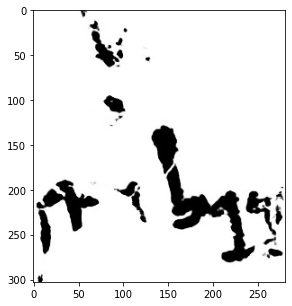

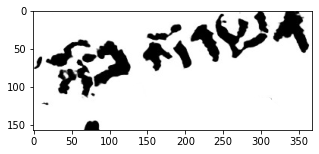

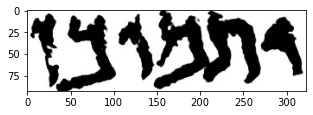

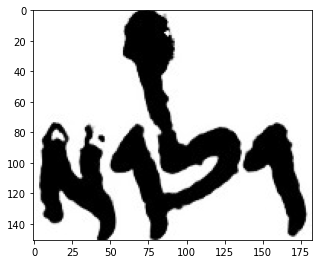

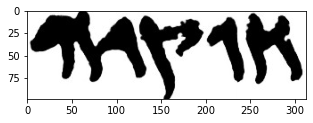

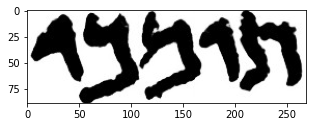

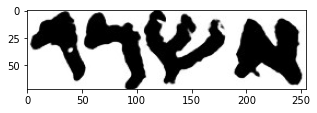

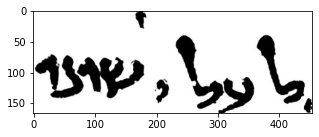

Line 1


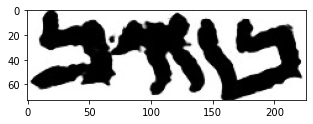

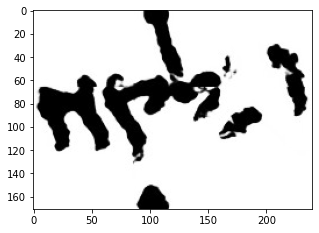

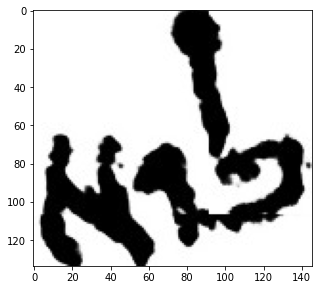

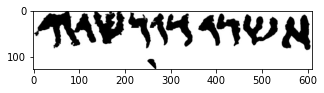

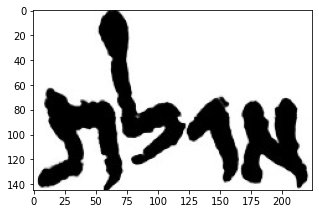

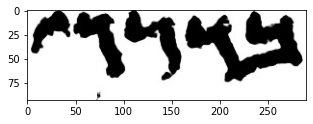

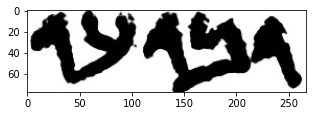

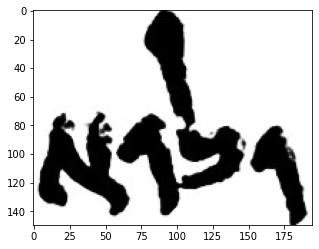

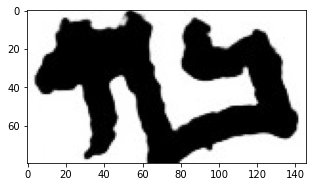

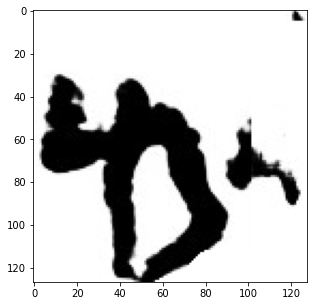

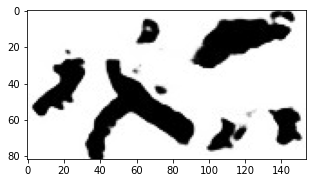

Line 2


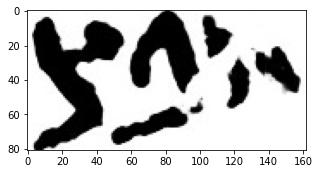

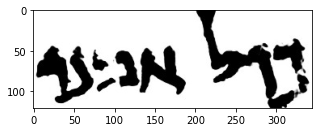

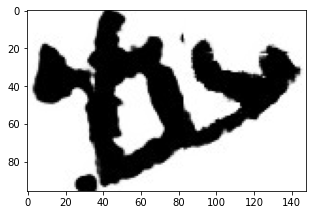

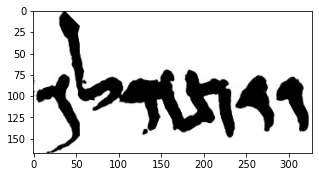

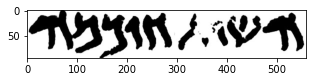

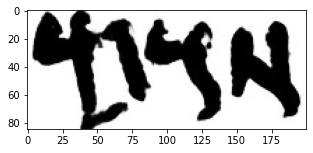

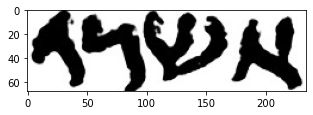

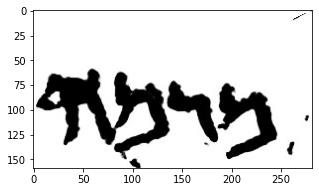

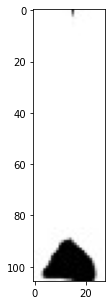

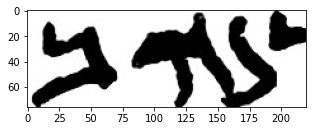

Line 3


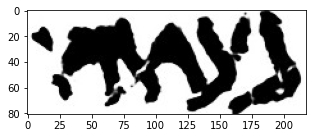

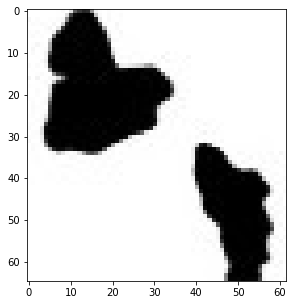

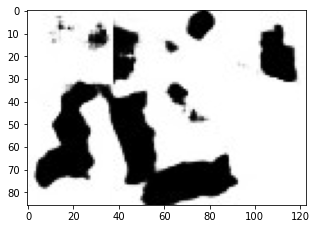

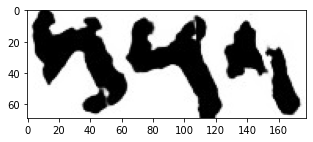

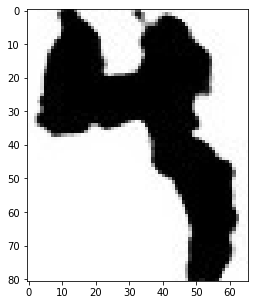

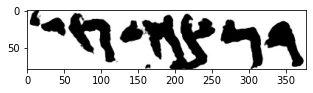

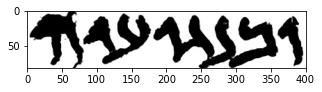

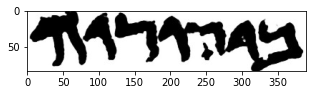

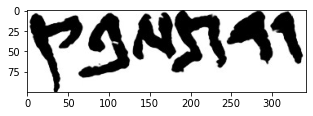

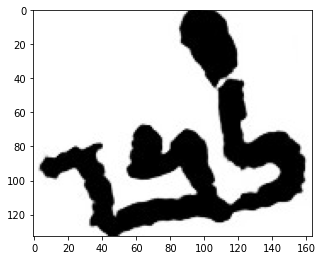

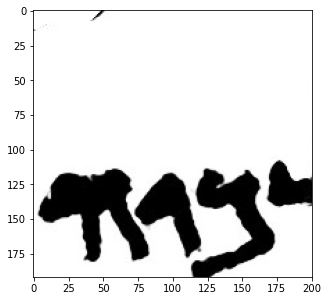

Line 4


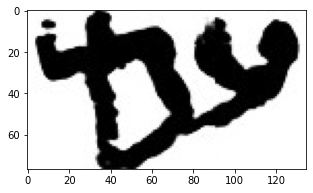

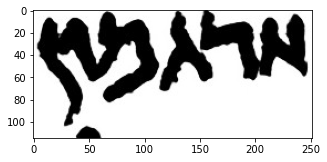

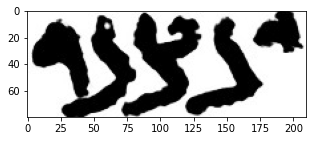

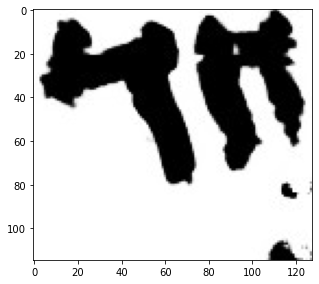

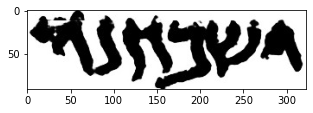

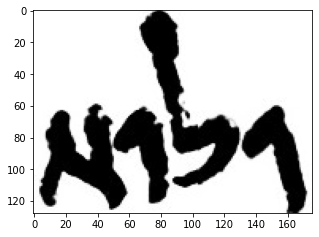

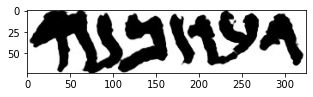

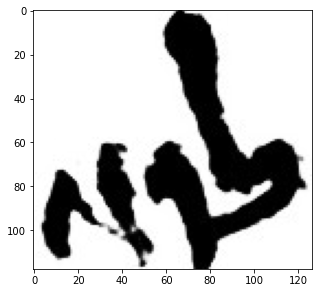

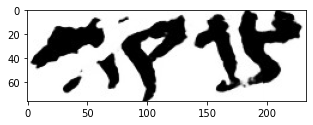

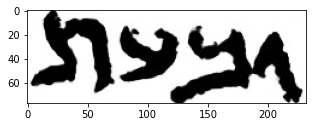

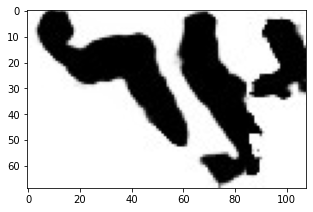

Line 5


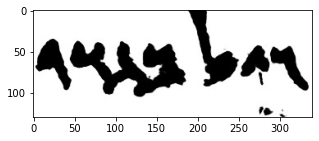

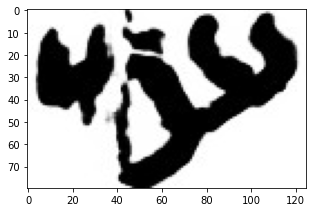

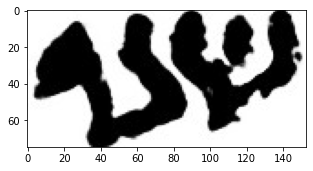

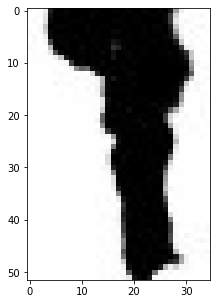

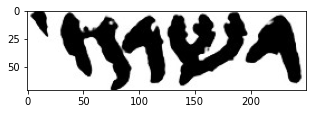

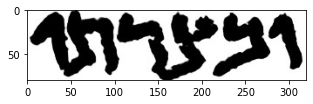

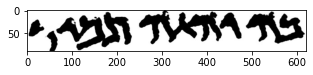

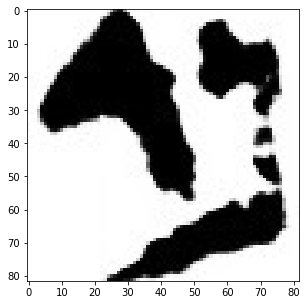

Line 6


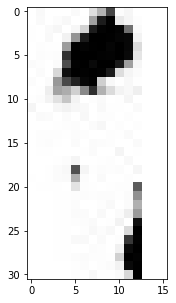

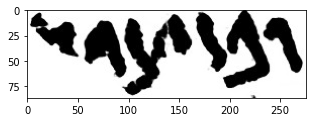

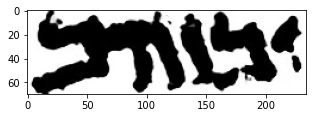

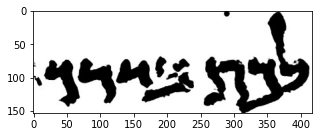

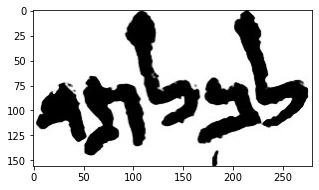

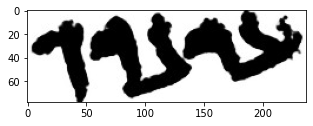

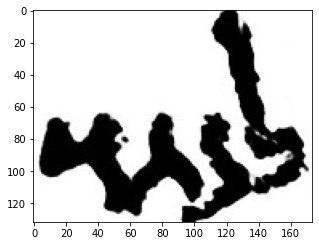

Line 7


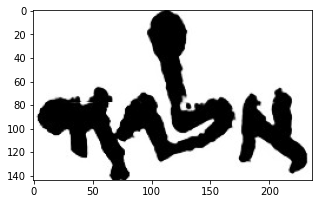

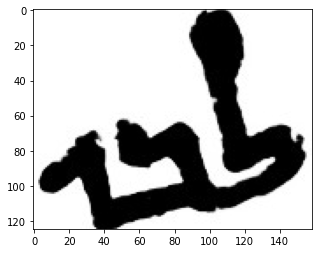

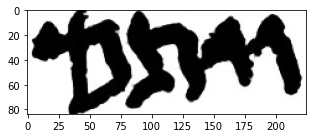

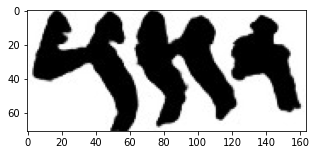

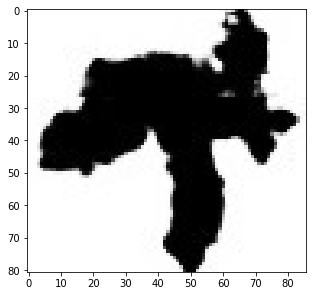

Line 8


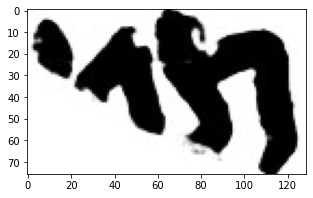

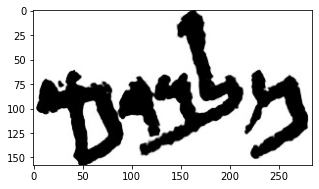

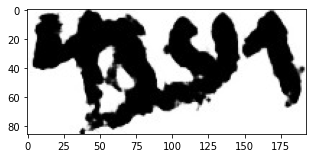

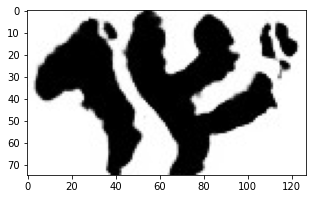

Line 9


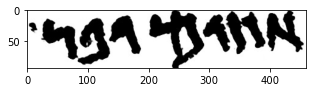

Line 10


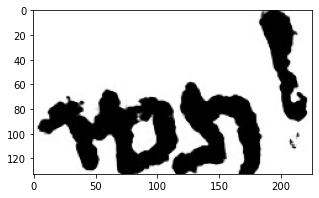

In [363]:
for row in range(len(words_per_line)):
    print("Line " + str(row))
    for word in range(len(words_per_line[row])):
        plt.figure(figsize=(5,5))
        plt.imshow(words_per_line[row][word], cmap="gray")
        plt.show()

In [335]:
len(words_per_line[0])

7

## Character Recognition copied from our github

In [19]:
import cv2
import numpy as np 
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import os 

In [20]:
# load monkbrill jpg data
data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill2/"
for subdir in os.listdir(data_path):
    if subdir == ".DS_Store":
        continue
    current_path = os.path.join(data_path, subdir)
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data['label'].append(subdir)
        data['filename'].append(file)
        data['data'].append(im)

In [21]:
# load monkbrill jpg augmented data if yet created
data_augmented = dict()
data_augmented['label'] = []
data_augmented['filename'] = []
data_augmented['data'] = []   

data_path = "/Users/joostfranssen/Documents/Study/MSc_AI/Year_1/Semester_2B/HWR/monkbrill-jpg-augmented/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)
    if subdir == ".DS_Store":
        continue
    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data_augmented['label'].append(subdir)
        data_augmented['filename'].append(file)
        data_augmented['data'].append(im)

In [22]:
# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels = encoder.fit_transform(data['label'])

# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels_augmented = encoder.fit_transform(data_augmented['label'])

In [23]:
original_test_data =  np.array(data['data'])
onehot_labels = encoder.fit_transform(data['label'])


X_train_aug, X_val_aug, y_train_aug, y_val_aug = train_test_split(data_augmented['data'], onehot_labels_augmented, test_size=0.2, random_state=0, shuffle=True)
X_train_aug = np.array(X_train_aug) / 255.0
y_train_aug = np.array(y_train_aug) 
X_val_aug = np.array(X_val_aug) / 255.0
y_val_aug = np.array(y_val_aug)

In [24]:
# Build LeNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(48, 38, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 38, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 19, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 15, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 7, 48)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 10, 7, 48)         0         
                                                                 
 flatten (Flatten)    

2022-06-01 08:45:42.723588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-01 08:45:42.723690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
# Compile and train model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
if not os.path.exists('models'):
        os.makedirs('models')
model_filepath = 'models/LeNet_model.h5'
callback = ModelCheckpoint(filepath=model_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train_aug, y_train_aug, epochs=10, validation_data = (X_val_aug, y_val_aug), callbacks = [callback], verbose=1)

Epoch 1/10


2022-06-01 08:45:43.451850: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   1/2456 [..............................] - ETA: 16:25 - loss: 3.3364 - accuracy: 0.0625

2022-06-01 08:45:43.670744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2455/2456 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.8892

2022-06-01 08:46:10.030475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2456/2456 [==============================] - 30s 12ms/step - loss: 0.3549 - accuracy: 0.8892 - val_loss: 0.1014 - val_accuracy: 0.9670
Epoch 2/10
2456/2456 [==============================] - 29s 12ms/step - loss: 0.0943 - accuracy: 0.9692 - val_loss: 0.0695 - val_accuracy: 0.9778
Epoch 3/10
2456/2456 [==============================] - 29s 12ms/step - loss: 0.0570 - accuracy: 0.9813 - val_loss: 0.0583 - val_accuracy: 0.9836
Epoch 4/10
2456/2456 [==============================] - 30s 12ms/step - loss: 0.0418 - accuracy: 0.9864 - val_loss: 0.0536 - val_accuracy: 0.9839
Epoch 5/10
2456/2456 [==============================] - 30s 12ms/step - loss: 0.0324 - accuracy: 0.9897 - val_loss: 0.0357 - val_accuracy: 0.9896
Epoch 6/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0282 - accuracy: 0.9914 - val_loss: 0.0495 - val_accuracy: 0.9865
Epoch 7/10
2456/2456 [==============================] - 31s 13ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0454 - val_accura

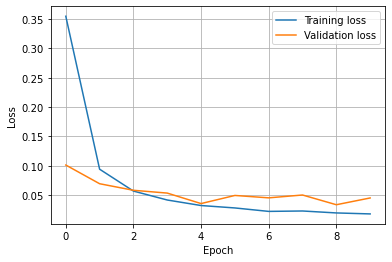

In [26]:
# Plot the loss
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

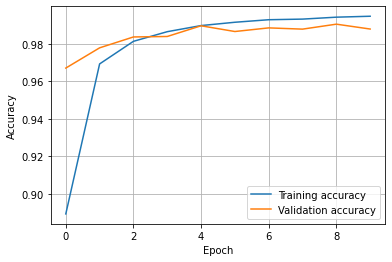

In [27]:
# Plot the accurcy
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [28]:
score_original_data = model.evaluate(original_test_data, onehot_labels, verbose = 0)
print('Test loss on original data:', score_original_data [0]) 
print('Test accuracy on original data:', score_original_data [1])

2022-06-01 08:50:42.740247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss on original data: 1.052268385887146
Test accuracy on original data: 0.9989164471626282


In [29]:
print("Generate a prediction")

prediction = model.predict(X_train_aug)
print("prediction:", prediction)

classes = np.argmax(prediction, axis = 1)
# for i in range(len(classes)):
#     print(classes[i])
    
count_arr = np.bincount(classes)
for i in range(len(count_arr)):
    print(str(i) + " number "  + str(count_arr[i])) 

Generate a prediction


2022-06-01 08:50:44.600275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


prediction: [[6.0888261e-20 1.6162184e-17 1.5466856e-17 ... 2.2168875e-15
  9.2448491e-20 9.9999988e-01]
 [9.0329633e-26 1.8442084e-34 2.0225596e-33 ... 6.2331401e-26
  4.3088308e-35 3.2835389e-23]
 [2.6049038e-14 5.1784868e-13 1.0856618e-13 ... 2.0659328e-09
  9.9524053e-16 9.9999988e-01]
 ...
 [0.0000000e+00 1.6276418e-24 3.3364633e-33 ... 0.0000000e+00
  0.0000000e+00 6.7264187e-38]
 [0.0000000e+00 5.4354082e-26 1.8531021e-31 ... 6.0815021e-35
  0.0000000e+00 6.1816145e-37]
 [1.0000000e+00 6.4152037e-21 6.1072494e-23 ... 1.7518084e-21
  3.0199359e-18 4.7296803e-22]]
0 number 2904
1 number 2888
2 number 3046
3 number 2774
4 number 2960
5 number 2938
6 number 2803
7 number 2833
8 number 2919
9 number 2920
10 number 2883
11 number 2962
12 number 2901
13 number 2899
14 number 2968
15 number 2867
16 number 3039
17 number 2914
18 number 2865
19 number 2853
20 number 2919
21 number 2944
22 number 2916
23 number 2884
24 number 2944
25 number 2879
26 number 2953


## Character segmentation

In [30]:
def boundingboxes_letters(image, image_dilated):
    boxcoordinates = []
    words_image = []
    letters = []

    copy = image.copy()
    thresholded = thresholding(image_dilated)

    cnts = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
        topleftx, toplefty, width, height = cv2.boundingRect(c)
        next_letter = [topleftx, toplefty, width, height]
        letters.append(next_letter)

    letters = sorted(letters, reverse=False)


    for letter in letters:
        topleftx, toplefty, width, height = letter

        #Reject contours that are too big or small to be likely letters, from average data taken
        #normal minima are height = 27, width = 17
        if height<40 or width<30:
            continue

        #normal maxima are height = 140, width = 80
        if height>300 or width>500:
            continue

        cv2.rectangle(copy, (topleftx, toplefty), (topleftx + width, toplefty + height), (0,0,255), 2)  
        boxcoordinates.append((topleftx, toplefty, width, height))

        character = image[toplefty:toplefty+height, topleftx:topleftx+width]
#        print("shape: "+str(character.shape))
#         plt.figure(figsize=(3,3))
#         plt.imshow(character, cmap="gray")
#         plt.show()
        words_image.append(character)
    
    return words_image, copy, boxcoordinates

In [31]:
def merge_bb_overlapping(char, coordinates, threshold):
    new_coordinates = []
    characters = []
    hit = 0
    for i in range(len(coordinates)-1):
        overlapping_size = (coordinates[i][0] + coordinates[i][2]) - coordinates[i+1][0]
        if overlapping_size > threshold and (coordinates[i][0] + coordinates[i][2]) > coordinates[i+1][0]:
            new_width = (coordinates[i+1][0] - coordinates[i][0]) + max(coordinates[i][2], coordinates[i+1][2])
            new_heigth = (coordinates[i+1][1] - coordinates[i][1]) + max(coordinates[i][3], coordinates[i+1][3])
            coordinate = (coordinates[i][0], max(coordinates[i][1], coordinates[i+1][1]), new_width, new_heigth )
            new_char = char[coordinate[0]:coordinate[0]+coordinate[2], coordinate[1]:coordinate[1]+coordinate[3]]
            characters.append(new_char)
            new_coordinates.append(coordinate)
            hit = 1
            continue 
        else:
            if hit != 1:
                print(coordinates[i][0])
                new_char = char[coordinates[i][0]:coordinates[i][0]+coordinates[i][2], coordinates[i][1]:coordinates[i][1]+coordinates[i][3]]
                characters.append(new_char)
                new_coordinates.append(coordinates[i])
                
        hit = 0
        
    new_char = char[coordinates[len(coordinates)-1][0]:coordinates[len(coordinates)-1][0]+ coordinates[len(coordinates)-1][2], coordinates[len(coordinates)-1][1]:coordinates[len(coordinates)-1][1]+coordinates[len(coordinates)-1][3]]
    characters.append(new_char)
    new_coordinates.append(coordinates[len(coordinates)-1]) 
    return characters, new_coordinates
        

# To add to erosion_char_finder:
##### A way to cover that if the len(new_new_char_bb) is 0 that we still seperate the word. (fixed; side note: just chopped it in halve)
##### Some seperations are going terribly wrong [1][2], [4][2]
##### At some cases the second boundingbox is above the other and therefore mistakes happen.  (fixed)
##### some letters can not be found [2][0] [][]
##### [5][3] [6][0] [3][1] [2][8] is een apart geval daar moet ook naar gekeken worden
##### [8][1]

## wat echt te implementeren:
#### divider als er twee of meer letters zijn met de peaks methode
#### zorgen dat al dat ding in zijn geheel een bounding box is het ook zo genomen word
####


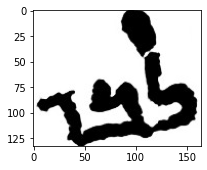

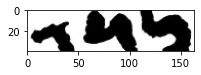

In [299]:
# image_to_divide = words_per_line[6][][:,:]

# plt.figure(figsize=(3,3))
# plt.imshow(image_to_divide, cmap="gray")
# plt.show()

# middle_part_image = find_middle_part_letter(image_to_divide)

# plt.figure(figsize=(3,3))
# plt.imshow(middle_part_image, cmap="gray")
# plt.show()

3


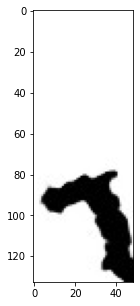

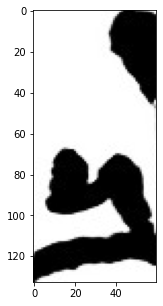

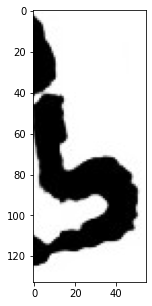

In [300]:
# characters = not_bb_divided(image_to_divide)
# print(len(characters))
# for i in range(len(characters)):
#     plt.figure(figsize=(5,5))
#     plt.imshow(characters[i], cmap="gray")
#     plt.show()

In [294]:
def find_middle_part_letter(image):
    hpp_image = thresholding(image)
    hpp_image = horizontal_projections(hpp_image)
    minimum_peak = int((np.max(hpp_image)-np.min(hpp_image))/3)
    peaks, _ = find_peaks(hpp_image, height=minimum_peak , distance=100)   
    toplefty = max(peaks[0]-20, 0)
    height = min(40, image.shape[0]-toplefty)
    new_image = image[toplefty:toplefty+height, :]
    
    return new_image
    

In [295]:
def not_bb_divider(image):
    vpp = vertical_projections(image)
    minimum_peak = int((np.max(vpp)-np.min(vpp))/3)
    peaks, _ = find_peaks(vpp, height=minimum_peak , distance=60)
    new_peaks = []
    for peak in peaks:
        #peaks lower than x value of 30 or 30 from end are not really dividers 
        if peak < 27:
            continue
        elif peak > (image.shape[1] - 27):
            continue
        else:
            new_peaks.append(peak)
        
    return new_peaks

In [296]:
def divided_chars(image, peaks):
    chars = []
    first_char = image[:,0:peaks[0]]
    chars.append(first_char)
    for i in range(len(peaks)):
        if i+1 == len(peaks):
            char = image[:,peaks[i]:image.shape[1]]
        else:
            char = image[:,peaks[i]:peaks[i+1]]
        chars.append(char)
    return chars
    

In [307]:
def not_bb_divided(image):
    character = []
    middle_part = find_middle_part_letter(image)
    peaks_divider = not_bb_divider(middle_part_image)
    characters = divided_chars(image, peaks_divider)
    for i in range(len(characters)):
        if characters[i].shape[0] == 0 or characters[i].shape[1] == 0:
            continue 
        else:
            character.append(characters[i])
    return character
    

In [394]:
def erosion_char_finder(double_char):
    characters = []
    erosion_level = 2
    kernel = np.ones((erosion_level,erosion_level), np.uint8)
    double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
    chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
    
    while len(chars) == 1:
        kernel = np.ones((erosion_level,erosion_level), np.uint8)
        double_char_dilate = cv2.dilate(double_char, kernel, iterations=1)
        chars, test_image, coordinates = boundingboxes_letters(double_char, double_char_dilate)
        erosion_level += 1
    
#     plt.figure(figsize=(5,5))
#     plt.imshow(test_image, cmap="gray")
#     plt.show()
        
    for x in range(len(chars)):
        #Too avoid that if we have a bb above another bb that it creates a new unwanted character
        if (x + 1) < len(chars) and coordinates[x+1][0] > coordinates[x][0] and coordinates[x+1][2] < (coordinates[x][2] - coordinates[x+1][0]):
            characters.append(double_char)
            break
        else:
            # print(erosion_level)
    #       (topleftx, toplefty, width, height)
            topleftx = max((coordinates[x][0] - 2), 0)

            #Often if we have two conjoint letters we have a too small bounding box for the last letter
            #Therefore we take the full bb of everything from the last letter onwards. 
            if x == (len(chars) -1):
                width = double_char.shape[1]-coordinates[x][0]
            else:
                width = min((coordinates[x][2] + 2), (double_char.shape[1]-coordinates[x][0]))
            new_char = double_char[:, topleftx:topleftx+width]
            characters.append(new_char)
    return characters

def find_characters_in_word(word):
    # character finder in total:
    word_copy = word.copy()

    #the first time we have a word we dilate such that we can find letters that are already seperated form others
    kernel = np.ones((3,3), np.uint8)
    word_copy_dilate = cv2.erode(word_copy, kernel, iterations=1)

    char, word_bb_image, coordinates = boundingboxes_letters(word_copy, word_copy_dilate)
    #print the image with the initial boundin boxes
#     plt.figure(figsize=(5,5))
#     plt.imshow(word_bb_image, cmap="gray")
#     plt.show()
    
    characters = []

    #If we do not find boundingboxes within the word, the word itself is a letter
    if len(char) == 0:
        characters.append(word_bb_image)
    else:
        for i in range(len(char)):
            if char[i].shape[1] > 85:
                new_char_bb = erosion_char_finder(char[i])
                if len(new_char_bb) == 0:
                    #of dit moet iets van 75 zijn of 86 ofzo
                    if char[i].shape[1] > 90:
                        characters_handcrafted_div = not_bb_divided(char[i])
                        for u in range(len(characters_handcrafted_div)):
                            characters.append(characters_handcrafted_div[u])
                    else:
                        characters.append(char[i])
                else:
                    for x in range(len(new_char_bb)):
                        if new_char_bb[x].shape[1] > 90:
                            new_new_char_bb = erosion_char_finder(new_char_bb[x])
                            if len(new_new_char_bb) == 0:
                                #if we have two letters that can not be seperated by erosion we chop in halve
                                #IF time left we can make a more efficient method for this
                                if new_char_bb[x].shape[1] > 86:
                                    characters_handcrafted_div = not_bb_divided(new_char_bb[x])
                                    for u in range(len(characters_handcrafted_div)):
                                        characters.append(characters_handcrafted_div[u])
                                else:
                                    characters.append(new_char_bb[x])
                            else:
                                if len(new_new_char_bb) == 1:
                                    if new_new_char_bb[0].shape[1] > 85:
                                        characters_handcrafted_div = not_bb_divided(new_char_bb[0])
                                        for u in range(len(characters_handcrafted_div)):
                                            characters.append(characters_handcrafted_div[u])
                                else:
                                    for y in range(len(new_new_char_bb)):
                                        characters.append(new_new_char_bb[y])
                        else:
                            characters.append(new_char_bb[x])
            else:
                characters.append(char[i])
    return characters

        
    

## Final characters testing for one word 

final chars: 
(45, 50)


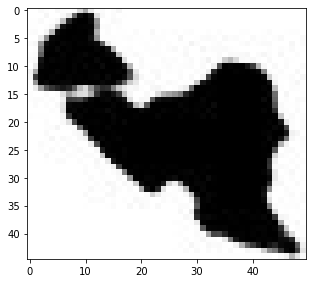

(57, 43)


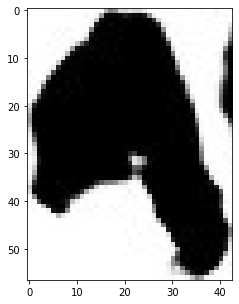

(82, 70)


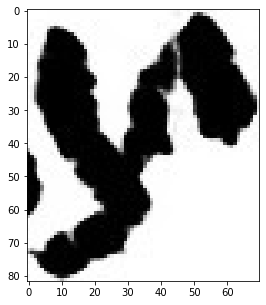

(78, 75)


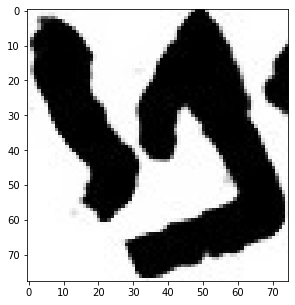

(56, 40)


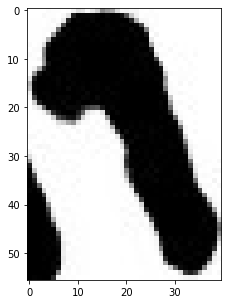

In [395]:
characters = find_characters_in_word(words_per_line[6][1][:,:])

print("final chars: ")
for y in range(len(characters)):
    plt.figure(figsize=(5,5))
    print(characters[y].shape)
    plt.imshow(characters[y], cmap="gray")
    plt.show()

## Final characters for all words 

In [396]:
def characters_per_line(words):
    char_per_word = []
    for i in range(len(words)):
        characters = find_characters_in_word(words[i])
        char_per_word.append(characters)
    return char_per_word
    

Word: 0
Character 0


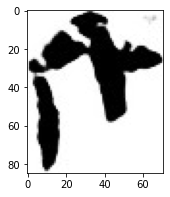

Character 1


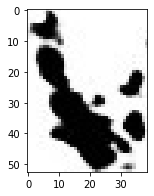

Character 2


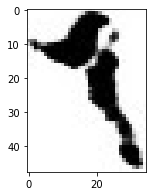

Character 3


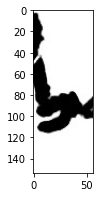

Character 4


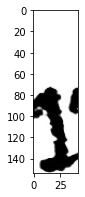

Character 5


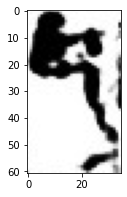

Word: 1
Character 0


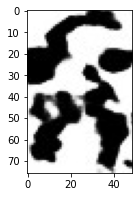

Character 1


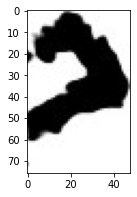

Character 2


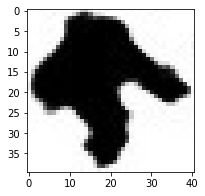

Character 3


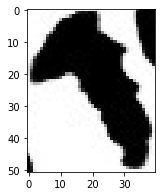

Character 4


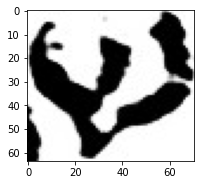

Character 5


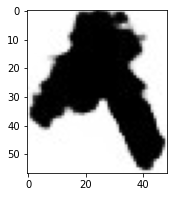

Word: 2
Character 0


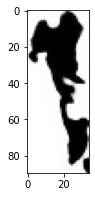

Character 1


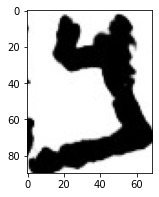

Character 2


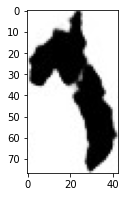

Character 3


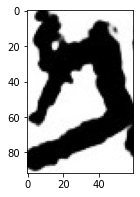

Character 4


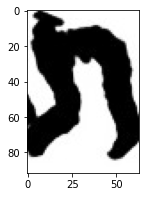

Character 5


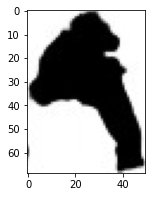

Word: 3
Character 0


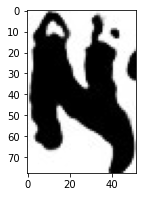

Character 1


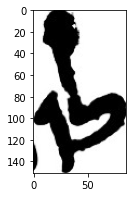

Character 2


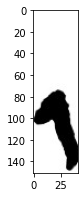

Word: 4
Character 0


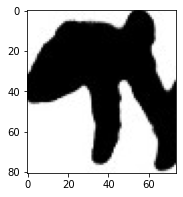

Character 1


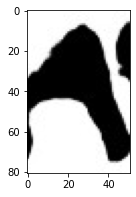

Character 2


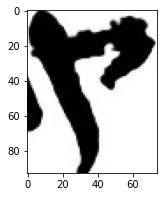

Character 3


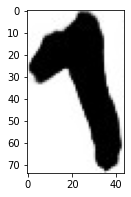

Character 4


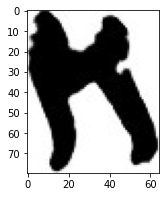

Word: 5
Character 0


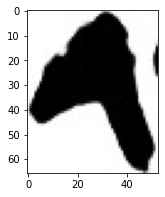

Character 1


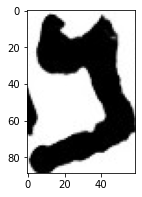

Character 2


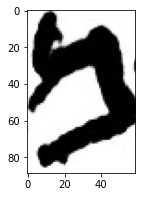

Character 3


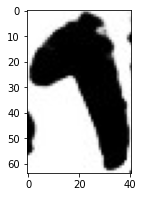

Character 4


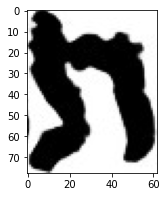

Word: 6
Character 0


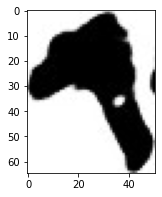

Character 1


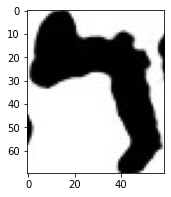

Character 2


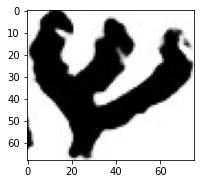

Character 3


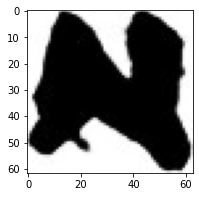

Word: 7
Character 0


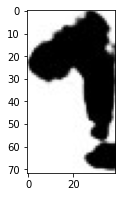

Character 1


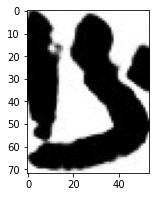

Character 2


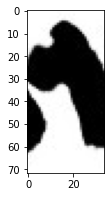

Character 3


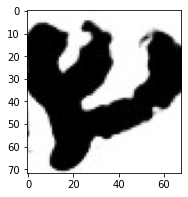

Character 4


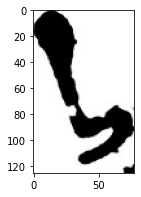

Character 5


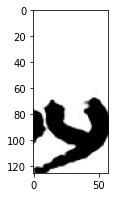

Character 6


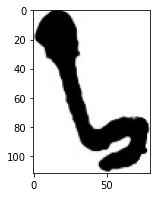

In [397]:
# print all characters from a specific line 
line_characters = characters_per_line(words_per_line[0])

for i in range(len(line_characters)):
    print("Word: " + str(i))
    for j in range(len(line_characters[i])):
        print("Character "+ str(j))
        plt.figure(figsize=(3,3))
        plt.imshow(line_characters[i][j], cmap="gray")
        plt.show()
        
        

## Now we can resize and input the seperate charachters into the model and make predictions

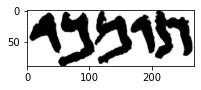

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0.]]
[25  8  7 24 20]


In [399]:
#Line_charachters = de woorden van line 1 pakt die nu 
line_characters = characters_per_line(words_per_line[0])

#we testen hier woord 6 van lijn 1
test_word = line_characters[5]

#foto van de letters als woord
plt.figure(figsize=(3,3))
plt.imshow(words_per_line[0][5], cmap="gray")
plt.show()


char_resized = []

for i in range(len(test_char)):
    test_char_resized = cv2.resize(test_char[i], (38, 48))
    char_resized.append(test_char_resized)
    

array = np.array(char_resized) 

#De predictions
predictions = model.predict(array)
print(predictions)
classes = np.argmax(predictions, axis = 1)
print(classes)